<div style="color:white;display:fill;border-radius:8px;
            background-color:#a7d5ed;font-size:170%;
            font-family:Nexa;letter-spacing:4.5px;">    
    <h1 style="padding:15px;color:black;text-align: center"> Ponto de partida (EDA) </h1> 
</div>

![](https://storage.googleapis.com/kaggle-competitions/kaggle/26480/logos/header.png?t=2021-04-09-00-57-05)

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> OBJETIVO </h1>    
</div>

Neste notebook vamos fazer uma análise (EDA) para conhencer os dados e estabelecer uma linha de base, mostrarei as etapas iniciais de uma competição da Flai - a compreensão do conjunto de dados até a preparação dos dados para serem usados em um modelo machine learning, vamos passar pelas seguintes tarefas:

- Leitura no conjunto de dados
- Calculando estatísticas sobre o conjunto de dados
- Visualização univariada
- Visualizando multivariada
- Pré-processamento 


<font color=green> **Definição do Problema**

Objetivo da Competição é prever o alugél de bicicleta, sendo a métrica de avaliação RMSE (root mean squared error), que  é a medida que calcula "a raiz quadrática média" dos erros entre valores observados (reais) e predições (hipóteses).

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 1. IMPORTAÇÕES </h1>    
</div>

## 1.1. Instalações

In [1]:
# https://pub.towardsai.net/use-google-colab-like-a-pro-39a97184358d
COLAB = 'google.colab' in str(get_ipython()) 

if COLAB:        
    !pip install --q scikit-plot
    !pip install --q category_encoders
    !pip install --q shap
    !pip install --q inflection    
    !pip install --q optbinning
    !pip install --q catboost
    !pip install --q pandas-profiling
    !pip install --q pycaret
        
    from google.colab import drive
    drive.mount('/content/drive')

## 1.2. Bibliotecas 

In [2]:
import warnings
import random
import os
import gc
import torch
import sklearn.exceptions
import datetime
import shap

In [3]:
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt 
import seaborn           as sns
import joblib            as jb
import xgboost           as xgb
import scipy.stats       as stats
import scipy.stats       as stats
import statsmodels.api   as sm

In [4]:
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.preprocessing   import StandardScaler, MinMaxScaler, RobustScaler 
from sklearn.preprocessing   import MaxAbsScaler, QuantileTransformer 
from sklearn.preprocessing   import PowerTransformer, Normalizer
from sklearn.preprocessing   import LabelBinarizer, OneHotEncoder, OrdinalEncoder
from sklearn                 import metrics
from sklearn.metrics         import ConfusionMatrixDisplay, confusion_matrix

In [5]:
from datetime                import datetime
from sklearn.ensemble        import VotingRegressor
from sklearn.compose         import TransformedTargetRegressor
from sklearn.pipeline        import Pipeline
from scipy.stats             import skew, norm
from scipy.stats             import norm
# from matplotlib.colors import ListedColormap

In [6]:
from yellowbrick.regressor       import ResidualsPlot
from yellowbrick.regressor       import PredictionError
from yellowbrick.model_selection import ValidationCurve

In [7]:
from lightgbm import LGBMRegressor

***

## 1.3. Funções
Aqui centralizamos todas as funções desenvolvidas durante o projeto para melhor organização do código.

In [8]:
class Ultil():
    
    import sklearn.exceptions
    
    def __init__(self):
        pass
    
    def jupyter_setting():
    
        %matplotlib inline

        #os.environ["WANDB_SILENT"] = "true" 
        #plt.style.use('bmh') 
        #plt.rcParams['figure.figsize'] = [20,15]
        #plt.rcParams['font.size']      = 13

        pd.options.display.max_columns = None
        #pd.set_option('display.expand_frame_repr', False)

        warnings.filterwarnings(action='ignore')
        warnings.simplefilter('ignore')
        warnings.filterwarnings('ignore')
        warnings.filterwarnings('ignore', category=DeprecationWarning)
        warnings.filterwarnings('ignore', category=FutureWarning)
        warnings.filterwarnings('ignore', category=RuntimeWarning)
        warnings.filterwarnings('ignore', category=UserWarning)
        warnings.filterwarnings("ignore", category=sklearn.exceptions.UndefinedMetricWarning)
        warnings.filterwarnings("ignore", category= sklearn.exceptions.UndefinedMetricWarning)

        pd.set_option('display.max_rows', 200)
        pd.set_option('display.max_columns', 500)
        pd.set_option('display.max_colwidth', None)

        icecream = ["#00008b", "#960018","#008b00", "#00468b", "#8b4500", "#582c00"]
        #sns.palplot(sns.color_palette(icecream))

        colors = ["lightcoral", "sandybrown", "darkorange", "mediumseagreen",
              "lightseagreen", "cornflowerblue", "mediumpurple", "palevioletred",
              "lightskyblue", "sandybrown", "yellowgreen", "indianred",
              "lightsteelblue", "mediumorchid", "deepskyblue"]

        # Colors
        dark_red   = "#b20710"
        black      = "#221f1f"
        green      = "#009473"
        myred      = '#CD5C5C'
        myblue     = '#6495ED'
        mygreen    = '#90EE90'    
        color_cols = [myred, myblue,mygreen]

        return icecream, colors, color_cols

    def missing_zero_values_table(df):
        mis_val         = df.isnull().sum()
        mis_val_percent = round(df.isnull().mean().mul(100), 2)
        mz_table        = pd.concat([mis_val, mis_val_percent], axis=1)
        mz_table        = mz_table.rename(columns = {df.index.name:'col_name', 
                                                     0 : 'Valores ausentes', 
                                                     1 : '% de valores totais'})
        
        mz_table['Tipo de dados'] = df.dtypes
        mz_table                  = mz_table[mz_table.iloc[:,1] != 0 ]. \
                                     sort_values('% de valores totais', ascending=False)
        
        msg = "Seu dataframe selecionado tem {} colunas e {} " + \
              "linhas. \nExistem {} colunas com valores ausentes."
            
        print (msg.format(df.shape[1], df.shape[0], mz_table.shape[0]))
        
        return mz_table.reset_index()
    
    def reduce_memory_usage(df, verbose=True):
    
        numerics = ["int8", "int16", "int32", "int64", "float16", "float32", "float64"]
        start_mem = df.memory_usage().sum() / 1024 ** 2

        for col in df.columns:

            col_type = df[col].dtypes

            if col_type in numerics:
                c_min = df[col].min()
                c_max = df[col].max()

                if str(col_type)[:3] == "int":
                    if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                        df[col] = df[col].astype(np.int8)
                    elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                        df[col] = df[col].astype(np.int16)
                    elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                        df[col] = df[col].astype(np.int32)
                    elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                        df[col] = df[col].astype(np.int64)
                else:
                    if (
                        c_min > np.finfo(np.float16).min
                        and c_max < np.finfo(np.float16).max
                    ):
                        df[col] = df[col].astype(np.float16)
                    elif (
                        c_min > np.finfo(np.float32).min
                        and c_max < np.finfo(np.float32).max
                    ):
                        df[col] = df[col].astype(np.float32)
                    else:
                        df[col] = df[col].astype(np.float64)
        end_mem = df.memory_usage().sum() / 1024 ** 2
        if verbose:
            print(
                "Mem. usage decreased to {:.2f} Mb ({:.1f}% reduction)".format(
                    end_mem, 100 * (start_mem - end_mem) / start_mem
                )
            )

        return df
    
    def graf_label(ax, total):

         for i in ax.patches:
            # get_width pulls left or right; get_y pushes up or down
            width, height = i.get_width() -.2 , i.get_height()

            x, y  = i.get_xy()  
            color = 'white'
            alt   = .5
            soma  = 0 

            if height < 70:
                color = 'black'
                alt   = 1
                soma  = 10

            ax.annotate(str(round((i.get_height() * 100.0 / total), 1) )+'%', 
                        (i.get_x()+.3*width, 
                         i.get_y()+soma + alt*height),
                         color   = color,
                         weight = 'bold',
                         size   = 14)
            
    def graf_bar(df, col, title, xlabel, ylabel, tol = 0):
    
        #ax    = df.groupby(['churn_cat'])['churn_cat'].count()
        ax     = df    
        colors = col

        if tol == 0: 
            total  = sum(ax)
            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           color   = colors, 
                           grid    = False)
        else:
            total  = tol     

            ax = (ax).plot(kind    ='bar',
                           stacked = True,
                           width   = .5,
                           rot     = 0,
                           figsize = (10,6),
                           color   = colors,
                           grid    = False)

        #ax.yaxis.set_major_formatter(mtick.PercentFormatter())

        #y_fmt = tick.FormatStrFormatter('%.0f') 
        #ax.yaxis.set_major_formatter(y_fmt)

        title   = title #+ ' \n'
        xlabel  = '\n ' + xlabel 
        ylabel  = ylabel + ' \n'

        ax.set_title(title  , fontsize=22)
        ax.set_xlabel(xlabel, fontsize=12)
        ax.set_ylabel(ylabel, fontsize=12)    

        min = [0,23000000]
        #ax.set_ylim(min)

        graf_label(ax, total)

    def graf_fature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                         print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                
    def describe(df):
        var = df.columns

        # Medidas de tendência central, média e mediana 
        ct1 = pd.DataFrame(df[var].apply(np.mean)).T
        ct2 = pd.DataFrame(df[var].apply(np.median)).T

        # Dispensão - str, min , max range skew, kurtosis
        d1 = pd.DataFrame(df[var].apply(np.std)).T
        d2 = pd.DataFrame(df[var].apply(min)).T
        d3 = pd.DataFrame(df[var].apply(max)).T
        d4 = pd.DataFrame(df[var].apply(lambda x: x.max() - x.min())).T
        d5 = pd.DataFrame(df[var].apply(lambda x: x.skew())).T
        d6 = pd.DataFrame(df[var].apply(lambda x: x.kurtosis())).T
        d7 = pd.DataFrame(df[var].apply(lambda x: (3 *( np.mean(x) - np.median(x)) / np.std(x) ))).T

        # concatenete 
        m = pd.concat([d2, d3, d4, ct1, ct2, d1, d5, d6, d7]).T.reset_index()
        m.columns = ['attrobutes', 'min', 'max', 'range', 'mean', 'median', 'std','skew', 'kurtosis','coef_as']

        return m

    def graf_outlier(df, feature):
        col = [(0,4), (5,9)]

        df_plot = ((df[feature] - df[feature].min())/
                   (df[feature].max() - df[feature].min()))

        fig, ax = plt.subplots(len(col), 1, figsize=(15,7))

        for i, (x) in enumerate(col): 
            sns.boxplot(data = df_plot.iloc[:, x[0]:x[1] ], ax = ax[i]); 

    def diff(t_a, t_b):
        from dateutil.relativedelta import relativedelta
        t_diff = relativedelta(t_b, t_a)  # later/end time comes first!
        return '{h}h {m}m {s}s'.format(h=t_diff.hours, m=t_diff.minutes, s=t_diff.seconds)

    def free_gpu_cache():

        # https://www.kaggle.com/getting-started/140636
        #print("Initial GPU Usage")
        #gpu_usage()                             

        #cuda.select_device(0)
        #cuda.close()
        #cuda.select_device(0)   

        gc.collect()
        torch.cuda.empty_cache()

    def graf_eval():

        results     = model.evals_result()
        ntree_limit = model.best_ntree_limit

        plt.figure(figsize=(20,7))

        for i, error in  enumerate(['mlogloss', 'merror']):#

            plt.subplot(1,2,i+1)
            plt.plot(results["validation_0"][error], label="Treinamento")
            plt.plot(results["validation_1"][error], label="Validação")

            plt.axvline(ntree_limit, 
                        color="gray", 
                        label="N. de árvore ideal {}".format(ntree_limit))


            title_name ='\n' + error.upper() + ' PLOT \n'
            plt.title(title_name)
            plt.xlabel("Número de árvores")
            plt.ylabel(error)
            plt.legend();

    def linear_fit_slope(y):
        """Return the slope of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return slope

    def linear_fit_intercept(y):
        """Return the intercept of a linear fit to a series."""
        y_pure = y.dropna()
        length = len(y_pure)
        x = np.arange(0, length)
        slope, intercept = np.polyfit(x, y_pure.values, deg=1)
        return intercept

    def cromer_v(x, y):
        cm       = pd.crosstab(x, y).to_numpy()        
        n        = cm.sum()
        r, k     = cm.shape
        chi2     = stats.chi2_contingency(cm)[0]
        chi2corr = max(0, chi2 - (k-1) * (r-1) /(n-1))
        kcorr    = k - (k-1) **2/(n-1)
        rcorr    = r - (r-1) **2/(n-1)    
        v        = np.sqrt((chi2corr/n) / (min(kcorr-1, rcorr-1)))        
        return v  

    def generate_category_table(data):

        cols    = data.select_dtypes(include='object').columns
        dataset = pd.DataFrame()

        for i in cols:
            corr = []
            for x in cols: 
                corr.append(Ultil.cromer_v(data[i],data[x]))

            aux     = pd.DataFrame({i:corr})
            dataset = pd.concat([dataset, aux], axis=1) 

        return dataset.set_index(dataset.columns)
            
    def graf_feature_corr(df_, annot_=False, threshold_=.8, print_var_=False, 
                          print_graf_=True, mask_=True, title_=''):

        df = df_.corr(method ='pearson').round(5)

        if print_graf_: 
            # Máscara para ocultar a parte superior direita do gráfico, pois é uma duplicata
            mask = np.zeros_like(df)
            mask[np.triu_indices_from(mask)] = mask_

            # Making a plot
            ax = sns.heatmap(df, annot=annot_, 
                             mask=mask, 
                             cmap="RdBu", 
                             annot_kws={"weight": "bold", "fontsize":13}
                            )

            ax.set_title("\n Correlação das variável {} \n".format(title_), fontsize=17)

            plt.setp(ax.get_xticklabels(), 
                     rotation      = 90, 
                     ha            = "right",
                     rotation_mode = "anchor", 
                     weight        = "normal")

            plt.setp(ax.get_yticklabels(), 
                     weight        = "normal",
                     rotation_mode = "anchor", 
                     rotation      = 0, 
                     ha            = "right")

            plt.show();

        if print_var_:         
            df_corr = df[abs(df)>threshold_][df!=1.0].unstack().dropna().reset_index()
            if len(df_corr)>0:            
                print('Variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))
                df_corr.columns =  ['var_1', 'var_2', 'corr']
                display(df_corr)
            else: 
                print('Não tem variáveis autocorrelacionadas threshold={:2.2f}'.format(threshold_))

    def plot_roc_curve(fpr, tpr, label=None):
        fig, ax = plt.subplots()
        ax.plot(fpr, tpr, "r-", label=label)
        ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.0])
        plt.rcParams['font.size'] = 12
        plt.title('ROC curve for FLAI 08')
        plt.xlabel('False Positive Rate (1 - Specificity)')
        plt.ylabel('True Positive Rate (Sensitivity)')
        plt.legend(loc="lower right")
        plt.grid(True)

    def feature_engineering(df_):

        var_f27 = ''
        for col in df_['f_27']: 
            var_f27 +=col

        var_f27 = list(set(var_f27))
        var_f27.sort()

        df_["fe_f_27_unique"] = df_["f_27"].apply(lambda x: len(set(x)))

        for letra in var_f27:             
            df_['fe_' + letra.lower() + '_count'] = df2_train["f_27"].str.count(letra)

        return df_ 

    def identifies_outliers(df):

        cols_num = df.select_dtypes(np.number).columns

        for col in cols_num: 
            if col != 'unnamed':            
                Q1  = df[col].quantile(0.25)
                Q3  = df[col].quantile(0.75)
                IQR = Q3-Q1
                lowqe_bound=Q1 - 1.5 * IQR
                upper_bound=Q3 + 1.5 * IQR

                df['outliers_'+ col] = 0
                df['outliers_'+ col][(df[col]<=lowqe_bound)|(df[col]>=upper_bound)] = 1    

                df[col] = np.where(df[col] > df[col].quantile(0.95),
                                                df[col].median(),
                                                df[col])

    def evaluation(y_, predictions_):
        mae  = metrics.mean_absolute_error(y_, predictions_)
        mse  = metrics.mean_squared_error(y_, predictions_)
        rmse = metrics.mean_squared_error(y_, predictions_, squared=False) 
        mape = metrics.mean_absolute_percentage_error(y_, predictions_)
        r2   = metrics.r2_score(y_, predictions_)    
        return rmse, mae, mse, mape, r2

In [9]:
icecream, colors, color_cols = Ultil.jupyter_setting()

---

## 1.4. Dataset

### 1.4.1. Descrição de dados

Para este desafio, temos o seguinte conjunto de dados com as seguintes variáveis: 

- **hora**: horário de aluguél da bicicleta;	
- **dia**: dia da semana 	
- **feriado**: indica se é feriado ou não;
- **estação**: estação do ano (Outono, Inverno, Primavera e Verão);
- **temperatura**: temperatura
- **chuva**: volume de chuva;
- **umidade**: umidade do ar;
- **sol**: sol
- **visibilidade**: visibilidade
- **vento**: velocidade do vendo 
- **aluguéis**: valor do aluguél da bicicleta (variável alvo)


### 1.4.2. Arquivos
- **treino.csv**: conjunto de treinamento;
- **teste.csv**: conjunto de teste, a tarefa é prever um o valor de aluguel. 

### 1.4.3. Estrutura de pasta
A finalidade é criar um estrutura de pasta para armazenar os artefatos criados no processo de análise e modelagem.

In [10]:
path        = '/content/drive/MyDrive/Flai/09/' if COLAB else ''   
path_data   = 'Data/'  
target      = 'aluguéis'
path_automl = 'automl/'

In [11]:
paths = ['img', 'Data', 'Data/pkl', 'Data/submission', 'Data/tunning', 
         'model', 'model/preds', 'model/optuna','model/preds/test', 'Data/shap',
         'model/preds/test/n1', 'model/preds/test/n2', 'model/preds/test/n3', 
         'model/preds/train', 'model/preds/train/n1', 'model/preds/train/n2', 
         'model/preds/train/n3', 'model/preds/param', 'model/mdl', 'model/preds/folds' ]

for p in paths:
    try:
        os.mkdir(path + p)       
    except:
        pass 

### 1.4.4. Carrega dados

In [12]:
df1_train     = pd.read_csv(path + path_data + 'treino.csv')
df1_test      = pd.read_csv(path + path_data + 'teste.csv')
df_submission = pd.DataFrame({target: np.zeros(df1_test.shape[0])})
df1_train.shape, df1_test.shape, df_submission.shape

((4500, 11), (3000, 10), (3000, 1))

In [13]:
df1_train.head()

,hora,dia,feriado,estação,temperatura,chuva,umidade,sol,visibilidade,vento,aluguéis
0,16,sábado,não,verão,39.4,0.0,61.1,2.19,92.0%,3.49,1318
1,21,sexta,não,primavera,22.2,0.0,63.3,0.00,32.0%,2.89,686
2,16,segunda,não,verão,40.5,0.0,52.8,2.51,93.0%,3.97,831
3,7,segunda,sim,outono,25.6,0.0,70.9,0.00,97.0%,1.09,15
4,9,segunda,não,verão,39.9,0.0,58.1,1.69,62.0%,1.09,865


In [14]:
df1_test.head()

,hora,dia,feriado,estação,temperatura,chuva,umidade,sol,visibilidade,vento
0,21,quinta,não,verão,33.3,0.12,72.4,0.0,88.0%,2.05
1,0,segunda,não,outono,25.0,0.00,73.1,0.0,34.0%,0.85
2,4,segunda,não,outono,22.1,0.00,67.9,0.0,97.0%,1.09
3,6,terça,não,verão,36.5,0.00,80.7,0.0,53.0%,1.93
4,21,quinta,não,verão,34.2,0.00,65.6,0.0,71.0%,2.05


In [15]:
def convert_visibilidade(df_):    
    list_visibilidade = []
    for c in df_['visibilidade'].values: 
        list_visibilidade.append(np.float64( c.replace('%', '')))        
    df_['visibilidade']= list_visibilidade    
    return df_

In [16]:
df1_train = convert_visibilidade(df1_train.copy())
df1_test  = convert_visibilidade(df1_test.copy())

In [17]:
df_dup = df1_train.value_counts().reset_index().iloc[:,-1]
indices_duplicados = df1_train.value_counts().reset_index().iloc[:,-1][df_dup>1].index
indices_duplicados

Int64Index([], dtype='int64')

In [18]:
import lux

In [20]:
df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/college.csv")
df

,Name,PredominantDegree,HighestDegree,FundingModel,Region,Geography,AdmissionRate,ACTMedian,SATAverage,AverageCost,Expenditure,AverageFacultySalary,MedianDebt,AverageAgeofEntry,MedianFamilyIncome,MedianEarnings
0,Alabama A & M University,Bachelor's,Graduate,Public,Southeast,Mid-size City,0.8989,17,823,18888,7459,7079,19500.0,20.629999,29039.0,27000
1,University of Alabama at Birmingham,Bachelor's,Graduate,Public,Southeast,Mid-size City,0.8673,25,1146,19990,17208,10170,16250.0,22.670000,34909.0,37200
2,University of Alabama in Huntsville,Bachelor's,Graduate,Public,Southeast,Mid-size City,0.8062,26,1180,20306,9352,9341,16500.0,23.190001,39766.0,41500
3,Alabama State University,Bachelor's,Graduate,Public,Southeast,Mid-size City,0.5125,17,830,17400,7393,6557,15854.5,20.889999,24029.5,22400
4,The University of Alabama,Bachelor's,Graduate,Public,Southeast,Small City,0.5655,26,1171,26717,9817,9605,17750.0,20.770000,58976.0,39200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1289,University of Connecticut-Avery Point,Bachelor's,Graduate,Public,New England,Mid-size Suburb,0.5940,24,1020,12946,11730,14803,18983.0,20.120001,86510.0,49700
1290,University of Connecticut-Stamford,Bachelor's,Graduate,Public,New England,Mid-size City,0.4107,21,1017,13028,4958,14803,18983.0,20.120001,86510.0,49700
1291,California State University-Channel Islands,Bachelor's,Graduate,Public,Far West,Mid-size Suburb,0.6443,20,954,22570,12026,8434,12500.0,24.850000,32103.0,35800
1292,DigiPen Institute of Technology,Bachelor's,Graduate,Private For-Profit,Far West,Small City,0.6635,28,1225,37848,5998,7659,19000.0,21.209999,68233.0,72800


In [25]:
df = pd.read_csv("https://raw.githubusercontent.com/lux-org/lux-datasets/master/data/hpi.csv")
df.default_display = "lux" # Set Lux as default display

In [27]:
df.intent = [lux.Clause(attribute='AverageCost')]
vis = df.exported[0]
vis

IndexError: list index out of range

***

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 2. Análise Exploratória de Dados (EDA) </h1>    
</div>

Antes de trabalhar com qualquer tipo de dados é importante entendê-los. Um passo crucial para esse objetivo é a Análise Exploratória de Dados (EDA): uma combinação de visualizações e análise estatística (uni, bi e multivariada) que nos ajuda a entender melhor os dados com os quais estamos trabalhando e obter insights sobre seus relacionamentos. Então, vamos explorar nossa variável de destino e como as outras variáveis a influenciam.

In [ ]:
df2_train = df1_train.copy()
df2_test  = df1_test.copy()

## 2.1. Dimensão do DataSet

In [ ]:
print('TREINO')
print('Number of Rows: {}'.format(df2_train.shape[0]))
print('Number of Columns: {}'.format(df2_train.shape[1]), end='\n\n')

print('TESTE')
print('Number of Rows: {}'.format(df2_test.shape[0]))
print('Number of Columns: {}'.format(df2_test.shape[1]))

---

## 2.2. Tipo de dados

In [ ]:
df2_train.info()

In [ ]:
df2_test.info()

In [ ]:
print(f'{3*"="} For Pandas {10*"="}\n{(df2_train.dtypes).value_counts()}')
print(f'\n{3*"="} For Datatable {7*"="}\n{(df2_test.dtypes).value_counts()}')

---

## 2.3. Identificar NA

In [ ]:
missing = Ultil.missing_zero_values_table(df2_train)
missing[:].style.background_gradient(cmap='Reds')

In [ ]:
missing = Ultil.missing_zero_values_table(df2_test)
missing[:].style.background_gradient(cmap='Reds')

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Não temos valores ausentes. 
</div>

## 2.4 Estatística Descritiva
Abaixo estão as estatísticas básicas para cada variável que contém informações sobre contagem, média, desvio padrão, mínimo, 1º quartil, mediana, 3º quartil e máximo.

In [ ]:
feature_float = df2_test.select_dtypes(np.number).columns.to_list()
feature_cat   = df2_test.select_dtypes(object).columns.to_list()

msg = 'Temos {} variávies numéricas e {} categóricas.'
print(msg.format(len(feature_float), len(feature_cat)))

- Train

In [ ]:
df2_train.describe().style.background_gradient(cmap='YlOrRd')

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- Um ponto que podemos destacar é em relação a variável alvo (aluguéis), com um desvio padrão muito alto muito próximo da média, 50% dos dados estão abaixo de 534.50 com um valor mínimo de 5.00 e o máximo de 3566.00, indicando que temos valores discrepantes, mais a frente vamos fazer uma análise mais detalhada.   <p>
    
- Um ponto que podemos destacar e que devemos analisar é a variável hora, **tem a caracteristica de discreta**, neste caso podemos transformá-la em categórica, o que pode ajudar os modelos na identificação de novos padrões e melharar a performance. <p> 
    
- Outro ponto são as variáveis contínuas, que pode ser necessário a **discretização**, com o intuito de reduzir a variância e consequentemente ajudar a modelagem, **precisamos fazer alguns testes**, pois algumas variáveis podem conter muitos valores que os algoritmos não podem identificar facilmente os padrões interessantes nos dados os quais são criados os modelos.
    
</div>

---

## 2.6. Distribuição

### 2.6.1. Train / Test

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

pie = ax.pie([len(df2_train), len(df2_test)],
             labels   = ["Train dataset", "Test dataset"],
             #colors   = ["teal", "b"],
             textprops= {"fontsize": 15},
             autopct  = '%1.1f%%')

ax.axis("equal")
ax.set_title("Comparação de comprimento do conjunto de dados \n", fontsize=18)
fig.set_facecolor('white')
plt.show();

---

### 2.6.2. Distribuição Train x Test

In [ ]:
features = df1_test.select_dtypes(np.number).columns

L    = len(features)
nrow = int(np.ceil(L/3))
ncol = 3

remove_last= (nrow * ncol) - L
sns.set(style="darkgrid")

fig, ax = plt.subplots(nrow, ncol,figsize=(15, 10))
fig.subplots_adjust(top=0.95)
i = 1

for feature in features:    
    plt.subplot(nrow, ncol, i)    
    ax = sns.kdeplot(df1_train[feature], shade=True, color='salmon',  alpha=0.5, label='train')
    ax = sns.kdeplot(df1_test[feature], shade=True, color='teal',  alpha=0.5, label='test')
    plt.xlabel(feature, fontsize=9)
    plt.legend()    
    i += 1
    
plt.suptitle('DistPlot: train & test data', fontsize=20)
plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

Observando os gráficos acima, as variáveis seguem a mesma distribuição em ambos os datasets, podemos destacar os seguintes pontos: 
- A variável hora tem uma distribuição uniforme, com essa distribuição podemos transformá-la em categórica, o que foi mencionado anteriormente;  <p>
    
- Outro ponto é a distribuição de cada variável, isto é, cada variável tem um distribuição, o que reforça que um **discretição** pode ajudar alguns algoritmos na modelagem.   

</div>

### 2.6.3. Proporção de variáveis

In [ ]:
fig, ax = plt.subplots(figsize=(5, 5))

plt.pie([ len(feature_cat), len(feature_float)], 
        labels=['Categorical', 'Continuos' ],
        textprops={'fontsize': 13},
        autopct='%1.1f%%')

#ax.axis("equal")
ax.set_title("Comparação variáveis continuas/categóricas \n Dataset Treino/Teste", fontsize=18)
fig.set_facecolor('white')
plt.show()

## 2.7. Dados Qualitativos

Vamos fazer uma contagem das observações e em cada variável categórica, para termos uma noção de como nosso conjunto de dados estar distribuído.

In [ ]:
for i in feature_cat:
    print("Coluna: ",i)
    print('TREINO:',  df2_train[[i]].value_counts(), '\n') 
    print('TESTE :',  df2_test[[i]].value_counts(), "\n")

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Vamos dar uma olhada na correlação das variaveis categóricas, criamos uma função que calcula a matriz de coeficientes de Cramer, que permite entender a correlação entre duas variáveis categóricas em um conjunto de dados.
</div>

### 2.7.1. Correlação
Primeira coisa que vamos fazer é criar um novo dataset e transformar a variável **hora** em categórica, assim vamos ter uma ideia da magnetute da variável como categórica. 

In [ ]:
df_cat         = df2_train.copy()
df_cat['hora'] = df_cat['hora'].astype(object)
f_cat          = feature_cat.copy()

f_cat.append('hora')

In [ ]:
sns.set_theme(style="whitegrid", palette="pastel")

plt.figure(figsize=(7,5))

df         = df_cat[f_cat].copy()
df[target] = df_cat[target].astype(object)

corr = Ultil.generate_category_table(df)
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, annot=True, mask= mask). \
         set_title('Correlação das variável categóricas', fontsize=17);

del df

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temos uma correlação baixa entre as variáveis categóricas, em relação a variável alvo uma razoavel correlação, a variável **estação** tem a maior correlção com a variável algo, é um idicativo que essa variável pode ser significativa para a modelagem. <p>
    
Vamos fazer uma análise de cada variável.

</div>

### 2.7.2. Análise univarianda

In [ ]:
sns.set(style="darkgrid")
plt.figure(figsize=(20,10))

for i, col in enumerate(f_cat):    
    plt.subplot(2, 2, i+1)
    sns.barplot(data=df_cat, x=col, y=target)
    plt.title('Variável {} '.format(col), fontsize=20)
    plt.xlabel('')

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- O dia que tem o menor valor de aluguél de bicicleta é no domingo;
- Quando temos feriado, o valor de aluguél é menor; 
- No verão é onde temos maior valor de aluguél de bicicleta; 
- No intervalor das 10h até as 18h temos um aumento no aluguél de bicicleta, com uma baixa as 19h até as 4h da manhã. <p>
    
Vamos fazer uma análise mais detalhada, com o cruzamento dessas variáveis.

</div>

### 2.7.3. Análise bivariada

In [ ]:
i=1
sns.set(style="darkgrid")
plt.figure(figsize=(20,20))
for col1 in (feature_cat):
    for x, col2 in enumerate(feature_cat):
        if col1!=col2:            
            plt.subplot(3,2, i)    
            sns.barplot(data=df2_train, x=col1, y=target, hue=col2);            
            plt.title('{} x {}'.format(col1, col2), fontsize=20)
            plt.xlabel('')
            i+=1

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

- Na sexta no verão temos um aumento no aluguél de bicicleta, isso também acontece no sabado de verão quando é feriado; 
- O verão é a estação do ano que temos o maior faturamento e no inverno com menor faturamento, o que pode ser um indicativo que a categoria (**inverno**) pode ser relevânte.  
    
</div>

## 2.8. Dados Quantitativos

### 2.8.1. Correlação
Vamos examinar a correlação entre as variáveis.

In [ ]:
sns.set(style="whitegrid", palette="pastel")
plt.figure(figsize=(10,7))

Ultil.graf_feature_corr(df_         = df2_train.copy(), 
                        annot_      = True, 
                        threshold_  = .7, 
                        print_var_  = True, 
                        print_graf_ = True, 
                        mask_       = False);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Como podemos observar, a correlação fica entre -0.6 e 0.5%, sendo assim, não temos variáveis autocorrelacionadas, mais a frente com a criação de novas variáveis podemos ter variáveis autocorrelacionadas e voltaremos a fazer essa análise de autocorrelação. <p>
    
Temos duas variáveis que tem correlação negativa com a variável algo, são elas: **chuva** e **umidade**, outro ponto é a variável dia **hora** com correlação com a variável alvo de 0.41, o que comprova que tranformação para categórica aumenta a correlação com a variável alvo. <p>   

    
</div>

### 2.8.3. Relação linear

In [ ]:
row    = int(len(feature_float)/2+1) 
fig,ax = plt.subplots(row,2,figsize=(15,15))
l      = 0 
c      = 0 

sns.set(style="darkgrid")

for i, col in enumerate(feature_float):
    sns.regplot(data        = df2_train, 
                x           = col, 
                y           = target,  
                scatter_kws = {'alpha':0.2}, 
                ax          = ax[l][c], 
                color       = '#3f72af',                 
               ) \
    .set_title('{} vs {}'.format(col, target), fontsize = 13)
    
    c  = 1 if c==0 else 0    
    l += 1 if i%2==1 else 0
        
fig.tight_layout(pad=3.0)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>

A variável que mais me chamou atenção é a variável **chuva**, que tem uma correlação negativa, mas quando olhamos o gráfico de regressão essa variável pode impactar negativamente os modelos em até -2000, outro ponto é que essa variável tem um concentração de valores com zero. Outra variável que tem um correlção negativa é a umidade, que não tem um padrão definido. 
    

</div>

In [ ]:
pd.plotting.scatter_matrix(df2_train, alpha = 0.3, figsize = (20,15), diagonal = 'kde');

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
 
Visualmente não consegue-se perceber pelo scatter_matrix uma curva (equação) que consiga descrever o relacionamento inter variáveis (como cada variável se relaciona com outra), visto que os pontos estão  dispersos. 
    
Uma pequena percepção que podemos notar é em relação a variável **chuva** com alguns pontos discrepantes. 

</div>

### 2.8.4. Outliers

In [ ]:
plt.figure(figsize=(15, 15))
f_flot = feature_float.copy() 
f_flot.append(target)

row = int(len(f_flot)/2)+1

for i, col in enumerate(f_flot):   
    plt.subplot(row, 2, i+1)
    sns.boxplot(y=col, data=df2_train);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Temos quatro variáveis com outliers na parte superior (acima da mediana), entre elas a variável **alvo**, o tratamento dos outliers pode resulta na melhoria do apredizado dos modelos, sendo assim, devemos fazer uma análise e utilizar algumas tecnicas de tratamento de outliers como: 
- Intervalo interquartil; 
- Z-score;
- Envelope Elíptico;
- Isolation Forest.  
</div>

## 2.9. Variáveis Alvo 


### 2.9.1. Teste de Normalidade
Para o teste de normalidade vamos utilizar o **Kolmogorov-Smirnov** da biblioteca do sklearn.

In [ ]:
test_ks   = stats.kstest(df2_train[target], 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'
if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))

### 2.9.2. Transformações 

In [ ]:
power  = PowerTransformer(method='box-cox') # 
y_ori  = df1_train[target] 
y_log  = np.log1p(y_ori)
y_sqr  = np.sqrt(y_ori)
y_bcox = pd.DataFrame(power.fit_transform(pd.DataFrame(y_ori)), columns=['y'])['y']
label  = ['Sem transformação','Log','Raiz quandrada', 'Box-Cox']

list_feature_trans = [y_ori, y_log, y_sqr, y_bcox]

plt.figure(figsize=(20,12))

msg = 'Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'

for i, v in enumerate(list_feature_trans):
    plt.subplot(3,4,i+1)
    (mu, sigma) = norm.fit(v)        
    sns.distplot(v, kde=True, hist=True, fit=norm)
    plt.legend([msg.format(mu, sigma)],loc='best')
    plt.xlabel('')
    plt.title('{}'.format(label[i]), fontsize=16)
    
    plt.subplot(3,4,i+5)
    sns.boxplot(y=v)
    
    plt.subplot(3,4,i+9)
    res = stats.probplot(v, plot=plt)
    plt.xlabel('')
    plt.title('')

plt.suptitle('Transformação da variável alvo ({})'.format(target), fontsize=20)
fig.tight_layout(pad=1.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Acima fizemos três transformações na variável alvo: log, raiz quadrada e box-cox, a primeira coluna é a variável sem tranformação, que tem uma distribuição assimétrica positiva com muitos outliers, no gráfico de probabilidade observamos que os valores não se comportam muito bem, indicado a não normalidade dos dados, em relação as transformações temos:   
    
- A transformação de log faz com que os dados tem uma distribuição assimétrica a esqueda e não consegue lidar muito bem com os outliers; <p>
    
- A transformação de raiz quadrada melhara o gráfico de distribuição, consegue lidar com os outliers como podemos observar no gráfico de boxplot com uma média comportada, mas não perfeito do gráfico de probalidade; <p>
    
- A transformação de box-cox tem uma distribuição boa no gráfico de distribuição, lida muito bem com os outliers, uma observação importante é que a média dos dados fica em torno do zero.
    
Vamos fazer o teste de normalidade nas transformações da raiz quadrada e box-cox.    
</div>

In [ ]:
test_ks   = stats.kstest(y_sqr, 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'

if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))


In [ ]:
test_ks   = stats.kstest(y_bcox, 'norm')
statistic = test_ks[0]
pvalue    = test_ks[1]

print('Estatística: {:2.8f}'.format(statistic))
print('P-value    : {:2.8f}'.format(pvalue))
print()

msg = 'Com nível de significância de 0.05 e confiança \nde 95%, os dados {} normalmente distribuidos.'
txt = 'são'

if pvalue<0.05: 
    txt = 'não são'
    
print(msg.format(txt))

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
  
As transformações utilizadas não foram capazes de normalizar os dados, mas vamos utlizar na modelagem a transformação de raiz quadrada, pois acredito que essa transformação pode ter efeito na modelage.
</div>

---

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 3. Modelagem </h1>    
</div>

In [ ]:
df3_train = df2_train.copy()
df3_test  = df2_test.copy()

df3_train.shape, df3_test.shape

## 3.1. Processamento 

In [ ]:
df3_train[f_cat].head()

In [ ]:
def feature_binarizer(df_tr_, df_vl_, df_ts_, features_ohe_=None, feature_ord_=None):

    if features_ohe_ is not None:
        for col in features_ohe_:         
            lb   = OneHotEncoder(sparse=False) # LabelBinarizer() OneHotEncoder
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )

            df_lb_tr = pd.DataFrame(lb.fit_transform (df_tr_[[col]]), columns=cols_fe)
            df_lb_vl = pd.DataFrame(lb.transform (df_vl_[[col]]), columns=cols_fe)
            df_lb_ts = pd.DataFrame(lb.transform (df_ts_[[col]]), columns=cols_fe)
            
            df_lb_tr[cols_fe]= df_lb_tr[cols_fe].astype(int)
            df_lb_vl[cols_fe]= df_lb_vl[cols_fe].astype(int)
            df_lb_ts[cols_fe]= df_lb_ts[cols_fe].astype(int)

            df_lb_tr.index =  df_tr_.index
            df_lb_vl.index =  df_vl_.index
            df_lb_ts.index =  df_ts_.index

            df_tr_ = pd.concat([df_tr_, df_lb_tr], axis=1)
            df_vl_ = pd.concat([df_vl_, df_lb_vl], axis=1)
            df_ts_ = pd.concat([df_ts_, df_lb_ts], axis=1)

            df_tr_.drop(col, axis=1, inplace=True)
            df_vl_.drop(col, axis=1, inplace=True)
            df_ts_.drop(col, axis=1, inplace=True)

    col     = ''
    cols_fe = ''

    if feature_ord_ is not None:
        for col in feature_ord_:
            ordEncoder = OrdinalEncoder()            
            cols = df_tr_[col].unique().tolist() 

            cols_fe = []
            for x in df_tr_[col].unique().tolist(): 
                cols_fe.append('fe_'+ col + '_' +str(x) )
                
            df_tr_[col] = ordEncoder.fit_transform(df_tr_[[col]])
            df_vl_[col] = ordEncoder.transform (df_vl_[[col]])
            df_ts_[col] = ordEncoder.transform (df_ts_[[col]])

    return df_tr_, df_vl_, df_ts_

## 3.1. Split Train/Test

In [ ]:
df3_train = Ultil.reduce_memory_usage(df3_train)
df3_test  = Ultil.reduce_memory_usage(df3_test)

In [ ]:
X      = df3_train.drop(target, axis=1)
y      = df3_train[target].values
X_test = df3_test

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      random_state = 12359)

cols_oho = ['estação', 'feriado',] 
cols_ord = ['dia']

X_train, X_valid, X_test = feature_binarizer(X_train.copy(), X_valid.copy(), X_test.copy(), cols_oho, cols_ord)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

## 3.2. Treinamento

In [ ]:
def delete_files(namefile):
                
        path = ['model/train', 'model/test', 'model/valid', 'model/params', 'model/score',
                'model/test_f', 'model/cv_model', 'model/preds', 'model/optuna', 
                'model/preds/train', 'model/preds/test', 'model/preds/test/n1', 
                'model/preds/test/n2', 'model/preds/test/n3', 'model/preds/train/n1', 
                'model/preds/train/n2', 'model/preds/train/n3','model/preds/param', 
                'Data/submission/tunning', 'Data/submission', 'model/mdl'                
               ]

        for path_ in path:
            for raiz, diretorios, arquivos in os.walk(path_):
                for arquivo in arquivos:
                    if arquivo.startswith(namefile):
                        os.remove(os.path.join(raiz, arquivo))

In [ ]:
cols = X_valid.columns.to_list()
cols_model_1 = cols
print(cols)

In [ ]:
%%time 
seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : 'rmse', 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,    #           
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})

scalers = [None, 
           #QuantileTransformer(output_distribution='normal', random_state=0)
           #StandardScaler(),
           #RobustScaler(), 
           #MinMaxScaler(), 
           #MaxAbsScaler(),                     
          ]

eval_set       = [(X_train[cols], y_train), (X_valid[cols], y_valid)]
model_baseline = xgb.XGBRegressor(**params)
scaler_best    = None
model_best     = None
score_best     = np.mean(y)
cols           = X_valid.columns
n_estimators   = int(model_baseline.get_params()['n_estimators']*.1)

for i , scaler in enumerate(scalers): 
    
    X_train_s = X_train[cols].copy() 
    X_valid_s = X_valid[cols].copy()
    X_test_s  = X_test[cols].copy()
    
    if scaler!=None:                      
        X_train_s[cols] = scaler.fit_transform(X_train_s[cols])
        X_valid_s[cols] = scaler.transform(X_valid_s[cols])
        X_test_s[cols]  = scaler.transform(X_test[cols])
    
    y_train_nor = y_train
    y_valid_nor = y_valid
    
    model_baseline.fit(X_train_s, 
                       y_train_nor, 
                       eval_set  = eval_set,                                               
                       verbose   = False, 
                       early_stopping_rounds = n_estimators
                      )

    score_tr  = model_baseline.score(X_train_s, y_train_nor)  
    y_pred_vl = model_baseline.predict(X_valid_s, ntree_limit=model_baseline.best_ntree_limit)
    y_pred_ts = model_baseline.predict(X_test_s,  ntree_limit=model_baseline.best_ntree_limit)
    
    y_pred_vl = np.int64(y_pred_vl)

    rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_valid, y_pred_vl)    
    
    msg = 'RMSE: {:2.2f} - MAE: {:2.2f} - MSE: {:2.2f} - MAPE: {:2.2f} - R2: {:2.2f} - RMSE Trn: {:2.8f} => {}'     
    print(msg.format(rmse, mae, mse, mape, r_squared, score_tr,  scaler))
    
    if (rmse)<score_best:        
        score_best   = (rmse)
        scaler_best  = scaler        
        #y_valid_best = np.float64(np.expm1(y_valid_nor))
        y_valid_best = y_pred_vl
        model_best   = model_baseline
        
    # Gera arquivo de submissão
    
    delete_files('xgb_01_base_line_score')
    
    name_file_sub         = 'xgb_01_base_line_score_{:2.2f}_{}.csv'.format(rmse, str(scaler).lower()[:4])
    df_submission[target] = np.int64(y_pred_ts)    
    df_submission.to_csv(path + 'Data/submission/' + name_file_sub, index=False)

df_pred = pd.DataFrame({'y': y_valid, 'y_pred':y_valid_best })
df_pred['residuals'] = df_pred['y'] - df_pred['y_pred']

print()
print('The Best')  
print('Scaler: {}'.format(scaler_best))    
print('Score : {:2.2f}'.format(score_best))
print()

# RMSE: 242.81 - MAE: 140.37 - MSE: 58958.17 - MAPE: 1.56 - R2: 0.85 - RMSE Trn: 0.98149293 => None

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Podemos destacar um ponto importante no resultado acima, **RMSE** é 42% acima do **MAE**, isso é um indicativo que os outliers estão afetando as previsões, pois a métrica (RMSE) é penalizada com os maiores erro da nossa previsão, sendo assim, temos um trabalho a fazer em relação aos outliers, que mencionamos nas análises.  <p>
    
Abaixo a submissão das previssões na competição com RMSE de 247.78 que representa um aumento de 0.02%, a minha maior preocupação é ter um modelo robusto, pois estamos sendo avaliado em 30% dos dados de treino, que torna a competição emocionante, pois as colocações podem muda no final.     
      
</div>

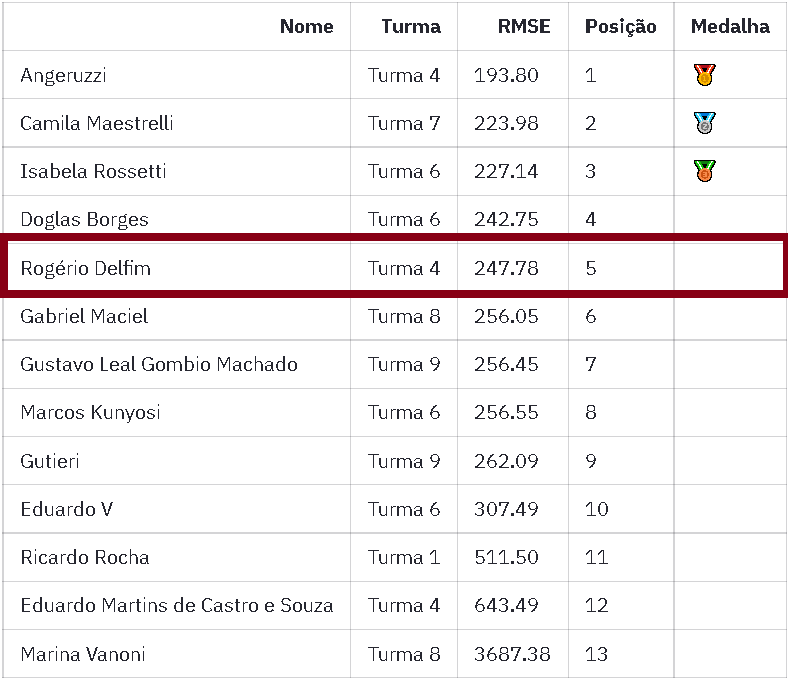

## 3.3. Anállise
Vamos começa plotando os valores real x preditos. 

### 3.3.1. Real x Predito

In [ ]:
sample = 200
x_ax   = range(len(y_valid[:sample]))

y_nor  = df_pred.loc[:sample-1].y
y_pred = df_pred.loc[:sample-1].y_pred

plt.figure(figsize=(15,10))

plt.subplot(3,1,1)
plt.plot(x_ax, y_nor,  label="original")
plt.plot(x_ax, y_pred, label="predicted")
plt.title("Previsão em dados de validação")
plt.legend()

plt.subplot(3,1,2)
plt.scatter(x_ax, y_nor, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()

plt.subplot(3,1,3)
result_tr   = model_best.evals_result()['validation_0']['rmse']
result_vl   = model_best.evals_result()['validation_1']['rmse']
ntree_limit = model_best.best_ntree_limit

#plt.figure(figsize=(12,5))
plt.plot(result_tr, label="Treinamento")
plt.plot(result_vl, label="Validação")
plt.axvline(ntree_limit, color="gray", label="N. de árvore ideal {}".format(ntree_limit))
plt.legend();

plt.show()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Observamos nos dois primeiros gráficos, que o modelo tem dificuldade nas previsões acima de 1000, isso é o sinal dos outliers que devemos tratá-los, no terceiro gráfico observamos que na predição o modelo utiliza quase os 1000 estimadores, talvez o aumento de estimadores pode melhorar as previsões, é ponto para tunning de parametros. 
</div>

### 3.3.2. Resíduo

In [ ]:
# https://www.scikit-yb.org/en/latest/api/regressor/index.html
plt.figure(figsize=(12,7))
visualizer = ResidualsPlot(model_best, hist=True,)
visualizer.fit(X_train_s, y_train_nor)  
visualizer.score(X_valid_s, y_valid_nor)
visualizer.show()   ;

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Obsevamos que temos alguma aleatóriedade nos resíduos, isso parece indicar que o modelo é bom, também podemos ver pelo histograma que nossos erros são quase normalmente distribuído em torno de zero, o que geralmente indica que o modelo precisa de ajuste, outro ponto importante é R2 do treinamento em relação ao teste, que é 13% acima indicando um overfiting, o qual podemos trabalhar em melhoria nos dados e parametros dos modelos. 
    
</div>

### 3.3.3. SHAP Values
Para uma análise detralhada das previsões vamos utilizar o **SHAP (SHapley Additive exPlanations)**, é uma técnica usada para interpretar os "black-box models" para explicar a saída de qualquer modelo de Machine Learning, com ele podemos ter uma maior explicabilidade dos impactos das variáveis nas predições.  <p>
        
O **SHAP mede o impacto das variáveis, levando em consideração a interação com outras variáveis**, isto é,  os valores de Shapley calculam a importância de uma variável comparando o que um modelo prevê com e sem a variável. No entanto, como a ordem na qual um modelo vê recursos pode afetar suas previsões, isso é feito em todas as ordens possíveis, para que as variáveis sejam comparados de maneira justa.[fonte](https://medium.com/@gabrieltseng/interpreting-complex-models-with-shap-values-1c187db6ec83) <p>
        
Ele conecta a alocação de crédito ideal com explicações locais usando os valores clássicos de Shapley da teoria dos jogos e suas extensões relacionadas ([ver artigos para detalhes e citações](https://github.com/slundberg/shap#citations) ). <br>

Desenvolvido por [Scott M. Lundberg.](https://scottlundberg.com/)

referências: <P>
- [Kaggle](https://www.kaggle.com/code/franckepeixoto/shap-values-explicando-os-impactos-das-vari-veis/notebook)
- Github: [1](https://github.com/slundberg/shap/blob/master/notebooks/tabular_examples/tree_based_models/Census%20income%20classification%20with%20LightGBM.ipynb) [2](https://slundberg.github.io/shap/notebooks/plots/dependence_plot.html)  <p>
    

#### 3.3.3.1. TreeExplainer 
Como estamos trabalhando com modelo de arvore vamos utilizar o **TreeExplainer**, sendo o mais apropriado para modelos baseados em arvore, foi otimizado para renderizar de forma mais eficaz os modelos em árvore, existem outras forma de calcular Shaply: 

- KernelExplainer para modelos lineares; 
- DeepExplainer no caso de modelos de Deep Learning.


In [ ]:
explainer   = shap.TreeExplainer(model_baseline)
shap_values = explainer.shap_values(X_train_s)

#### 3.3.3.2. Featuere Importance

In [ ]:
shap.summary_plot(shap_values, X_train_s, plot_type="bar")

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>
Aqui temos uma visão das variáveis mais importante no treinamento do modelo, percebemos que a tempera e hora são as mais importante, com uma grande diferença em relação as outras variáveis. 
    
Vamos dar uma olhada no efeito de cada variável na predição do modelo. 
    
    
</div>

#### 3.3.3.3. Impacto da variável 

In [ ]:
shap.summary_plot(shap_values, X_train_s, max_display=15)

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p><br>  
A temperatura e a hora são duas variáveis que tem um auto impacto positivo nas previsões, as variáveis umidade e chuva tem um impacto negativo nas previsões.
</div>

#### 3.3.3.4. Gráfico de força coletiva

Cada observação tem seu próprio gráfico de força. Se todos os gráficos de força são combinados, girados 90 graus e empilhados horizontalmente.


In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train_s)

In [ ]:
inds = shap.approximate_interactions("temperatura", shap_values, X_train_s)

for i in range(10):
    shap.dependence_plot("temperatura", shap_values, X_train_s, interaction_index=inds[i])

In [ ]:
feature = X_train_s.columns
row     = int(len(feature)/2 )
fig, ax = plt.subplots(row, 2, figsize=(15,30))
l       = 0
c       = 0 

for i, name in enumerate(feature):   
    shap.dependence_plot(name, 
                         shap_values[:1000], 
                         X_train_s[:1000], 
                         display_features  = X_train_s, 
                         ax                = ax[l][c], 
                         #interaction_index = None, 
                         show              = False
                        )
    
    c  = 1 if c==0 else 0    
    l += 1 if i%2==1 else 0    

fig.tight_layout(pad=3.0)

## 3.4. Validação Cruzada

In [ ]:
X      = df3_train.drop(target, axis=1)
y      = (df3_train[target])
X_test = df3_test

cols_oho = ['estação', 'feriado',] 
cols_ord = ['dia']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, 
                                                      test_size    = 0.2,
                                                      shuffle      = True, 
                                                      random_state = 12359)


X_train, X_valid, X_test = feature_binarizer(X_train.copy(), X_valid.copy(), X_test.copy(), cols_oho, cols_ord)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape , X_test.shape

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def save_data_model(model_, model_name_, path_, df_, y_pred_test_prob_, y_pred_test_subm_, score_, 
                    seed_, level_='1', target_='target', cutoff_value_=.6, gera_submission_=True):    
    
    level = 'n' + level_ + '/'

    if score_>cutoff_value_:    
        
        path_name_param = path_ + 'model/preds/param/' + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_train = path_ + 'model/preds/train/' + level + model_name_.format(score_, seed_) + '.pkl.z'
        path_name_test  = path_ + 'model/preds/test/'  + level + model_name_.format(score_, seed_) + '.pkl.z'   
        path_name_model = path_ + 'model/mdl/'         + model_name_.format(score_, seed_) + '.pkl.z'   
        
        delete_files(model_name_)
        
        jb.dump(df_, path_name_train)
        jb.dump(y_pred_test_prob_, path_name_test)
        jb.dump(model_, path_name_model)
                
        if gera_submission_:
            model_name_ = model_name_.format(score_, seed_)
            df_submission[target] = y_pred_test_subm_
            df_submission.to_csv(path_ + 'Data/submission/' + model_name_+ '.csv', index=False)

In [ ]:
def df_return_preds_stacking(model_name_=None, path_='', target_='target', level=1): 

    if level==1: 
        level_ = 'n1'
    else: 
        if level==2:
            level_ = 'n2'
        else: 
            level_ = 'n3'

    paths = ['model/preds/test/'+ level_, 'model/preds/train/' + level_ ]    

    if model_name_==None: 
        model_name_=''

    for i, p in enumerate(paths): 

        p = path_ + p 

        name_file_pkl     = glob.glob(p + '/'+ model_name_ + '*.pkl.z')
        dic_preds_mdl_pkl = dict()    

        for p_name in name_file_pkl:    
            y_model_pkl_name_col  = p_name.replace(p + '\\', '').replace('.pkl.z','') 
            #y_model_pkl           = jb.load(p_name)
            df_pkl =jb.load(p_name)

            if i==0: 
                x_proba = df_pkl
            else: 
                x_proba = df_pkl['y_proba']        

            dic_preds_mdl_pkl[y_model_pkl_name_col] = x_proba

        if i==0:
            df_ts = pd.DataFrame(dic_preds_mdl_pkl)
        else: 
            df_tr = pd.DataFrame(dic_preds_mdl_pkl) 
            df_tr[target_] = df_pkl['y_proba']
            
    return df_tr, df_ts 

In [ ]:
def cross_val_model(model_, model_name_, X_, y_, X_test_, target_, scalers_, lb_, fold_=5, path_='',  
                    seed_=12359, feature_scaler_=None, print_report_=False, save_submission_=False, 
                    save_predict_=False, level_='1', cutoff_value_save_=.6, 
                    train_with_created_folds_=False):
    
    n_estimators    = model_.get_params()['n_estimators']             
    valid_preds     = {}
    taco            = 76 
    acc_best        = 0  
    df_preds        = pd.DataFrame()
    feature_imp     = pd.DataFrame()
    test_preds      = []
    preds           = []
    model           = []
    folds           = []
    cols_sencond_level = ['fold', 'idx_fold', 'y', 'y_pred', 'residuo']
    
    # Recuperar os indices do kf 
    if train_with_created_folds_:
        for i in range(fold_):         
            folds.append(jb.load(path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(fold_, i+1)))
    else:
        #folds = KFold(n_splits=fold_, shuffle=True, random_state=12359)
        folds = StratifiedKFold(n_splits=fold_, shuffle=True, random_state=12359)
        folds = folds.split(X_, y_)
        

    for i, scaler_ in enumerate(scalers_): 

        time_start  = datetime.now()
        score     = [] 
        score_mae = []
                
        if scaler_!=None:            
            string_scaler = str(scaler_)        
            string_scaler = string_scaler[:string_scaler.index('(')]
        else:
            string_scaler = None 
            
        y_pred_test = np.zeros(len(X_test_))        
        
        print('='*taco)
        print('Scaler: {} - n_estimators: {}'.format(string_scaler, n_estimators))
        print('='*taco)
        
        y_pred_test_oof = 0      
        second_level    = np.zeros((X_.shape[0], 5))        

        for fold, (trn_idx, val_idx) in enumerate(folds): 

            time_fold_start = datetime.now()
            
            if train_with_created_folds_:
                trn_idx = folds[fold][trn_idx]
                val_idx = folds[fold][val_idx]
            
            # ---------------------------------------------------- 
            # Separar dados para treino 
            # ----------------------------------------------------     
            X_trn, X_val = X_.iloc[trn_idx], X_.iloc[val_idx]
            y_trn, y_val = y_.iloc[trn_idx], y_.iloc[val_idx] 
                      
            # ---------------------------------------------------- 
            # Processamento 
            # ---------------------------------------------------- 
            X_tst = X_test_.copy()
            
            if scaler_!=None: 
                if feature_scaler_!=None:                     
                    X_trn[feature_scaler_] = scaler_.fit_transform(X_trn[feature_scaler_])
                    X_val[feature_scaler_] = scaler_.transform(X_val[feature_scaler_])                      
                    X_tst[feature_scaler_] = scaler_.transform(X_tst[feature_scaler_])
                else:            
                    X_trn = scaler_.fit_transform(X_trn)
                    X_val = scaler_.transform(X_val)
                    X_tst = scaler_.transform(X_tst.copy())
                
            # ---------------------------------------------------- 
            # Treinar o modelo 
            # ----------------------------------------------------            
            model_.fit(X_trn, y_trn,
                       eval_set              = [(X_trn, y_trn), (X_val, y_val)],          
                       early_stopping_rounds = int(n_estimators*.1),
                       verbose               = False
                      )
            
            # ---------------------------------------------------- 
            # Predição 
            # ----------------------------------------------------                 
            y_pred_val       = model_.predict(X_val, ntree_limit=model_.best_ntree_limit)
            y_pred_test_oof += model_.predict(X_tst, ntree_limit=model_.best_ntree_limit) / fold_
                        
            second_level[val_idx, 0] = fold+1 
            second_level[val_idx, 1] = val_idx 
            second_level[val_idx, 2] = y_val.values
            second_level[val_idx, 3] = y_pred_val 
            second_level[val_idx, 4] = np.int64(y_val.values - y_pred_val) 
            
            # ---------------------------------------------------- 
            # Score 
            # ----------------------------------------------------                         
            rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_val, y_pred_val)  
                       
            score.append(rmse)     
            score_mae.append(mae)
            
            # ---------------------------------------------------- 
            # Feature Importance
            # ----------------------------------------------------             
            feat_imp = pd.DataFrame(index   = X_.columns,
                                    data    = model_.feature_importances_,
                                    columns = ['fold_{}'.format(fold+1)])

            feat_imp['rmse_'+str(fold+1)] = rmse
            feature_imp = pd.concat([feature_imp, feat_imp], axis=1)
            
            # ---------------------------------------------------- 
            # Print resultado  
            # ---------------------------------------------------- 
            time_fold_end = Ultil.diff(time_fold_start, datetime.now())
            msg = '[Fold {}] RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}  - {}'
            print(msg.format(fold+1, rmse, mae, mape, time_fold_end))
            
            # ---------------------------------------------------- 
            # Salvar o modelo 
            # ---------------------------------------------------- 
            dic_model = {'scaler' : scaler_, 
                         'fold'   : fold+1, 
                         'model'  : model_ }
            
            model.append(dic_model)
        
        df_preds           = pd.DataFrame(second_level, columns=cols_sencond_level)
        df_preds['scaler'] = string_scaler
        
        for col in ['fold', 'idx_fold', 'y', 'y_pred']:
            df_preds[col] = df_preds[col].astype(np.int)
        
        score_mean     = np.mean(score) 
        score_std      = np.std(score)
        score_mae_mean = np.mean(score_mae)
        
        if score_mean > acc_best:     
            acc_best    = score_mean           
            model_best  = model_    
            scaler_best = scaler_

        time_end = Ultil.diff(time_start, datetime.now())   

        msg ='[Mean Fold] RMSE: {:2.2f} std: {:2.2f} - MAE {:2.2f} - {}'
        
        print('-'*taco)        
        print(msg.format(score_mean,score_std, score_mae_mean, time_end))
        print('='*taco)
        print()
                                         
        # Salvar as predições
        if save_submission_:        
            y_pred_test_oof = np.int64(y_pred_test_oof)
            save_data_model(model_             = model_, 
                            model_name_        = model_name_+'_score_{:2.5f}_seed_{}_'+str(scaler_).lower()[:4], 
                            path_              = path_,                             
                            df_                = df_preds,          # stacking
                            y_pred_test_prob_  = y_pred_test_oof,   # stacking 
                            y_pred_test_subm_  = y_pred_test_oof,   # sumission 
                            score_             = score_mean, 
                            seed_              = seed_, 
                            level_             = level_, 
                            target_            = target_, 
                            cutoff_value_      = cutoff_value_save_) 
            
    print('-'*taco)
    print('Scaler Best: {}'.format(scaler_best))
    print('Score      : {:2.2f}'.format(acc_best))
    print('-'*taco)
    print()
    
    Ultil.free_gpu_cache()
    
    return model, df_preds , feature_imp , val_idx, y_val

In [ ]:
def create_kfolds(folds, X_, y_):

    kf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=12359)

    for fold, (trn_idx, val_idx) in enumerate(kf.split(X_, y_, groups=y_)):   
        idx  = {'trn_idx': trn_idx, 'val_idx': val_idx}
        file = path + 'model/preds/folds/kf_folds_{}_{}.pkl.z'.format(folds,fold+1)
        jb.dump(idx, file)
        print('Fold: {}'.format(fold+1))

### 3.4.1 Treinar com 5 Folds

In [ ]:
create_kfolds(5, X, y)

In [ ]:
%%time 

seed        = 12359
eval_metric = ['rmse']                 
scalers     = [None]               

seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : 'rmse', 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,    #           
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_name = 'xgb_02_cv_05_folds'

delete_files(model_name)

model, df_preds, feature_imp, val_idx, y_val = \
    cross_val_model(model_           = xgb.XGBRegressor(**params),
                    model_name_      = model_name,
                    X_               = X,
                    y_               = y,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 5,
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None,                     
                    save_submission_ = True, 
                    train_with_created_folds_ = True
                   )

print()

### 3.4.1 Treinar com 10 Folds

In [ ]:
%%time 

seed        = 12359
eval_metric = ['rmse']                 
scalers     = [None]               

seed   = 12359
params = {'objective'        : 'reg:squarederror', 
          'eval_metric'      : eval_metric, 
          'n_estimators'     : 2000,         
          'max_depth'        : 7, 
          'learning_rate'    : .01, 
          'subsample'        : 0.7, 
          'colsample_bytree' : 0.8, 
          'reg_alpha'        : 0.9,
          'random_state'     : seed}

if torch.cuda.is_available():           
    params.update({'tree_method': 'gpu_hist','predictor': 'gpu_predictor'})
    
model_name = 'xgb_03_cv_10_folds'

delete_files(model_name)

model, df_preds, feature_imp, val_idx, y_val = \
    cross_val_model(model_           = xgb.XGBRegressor(**params),
                    model_name_      = model_name,
                    X_               = X_train,
                    y_               = y_train,
                    X_test_          = X_test,
                    target_          = target,
                    scalers_         = scalers,
                    fold_            = 10,
                    lb_              = None,
                    path_            = path,
                    seed_            = seed, 
                    feature_scaler_  = None,                     
                    save_submission_ = True 
                   )
print()

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Com o aumento de folds o modelo melhora o score, mas a variância duplica. 
    
</div>

## 3.5. Análise do Modelo 

### 3.5.1. Feature Importances  

In [ ]:
plt.figure(figsize=(15,25))

cols  = feature_imp.filter(regex=r'fold').columns.to_list()
folds = len(cols)
row   = int(folds/2+1)

for fold, col in enumerate(cols):            
    col_acc = 'rmse_' + str(fold+1)
    df_fi = feature_imp.sort_values(by=col, ascending=False).reset_index().iloc[:15]
    df_fi = df_fi[['index', col, col_acc]]
    df_fi.columns = ['Feature', 'score', col_acc]
    plt.subplot(row, 2, fold+1)
    sns.barplot(x='score', y='Feature', data=df_fi)    
    plt.title('Fold {} - score: {:2.2f}'.format(fold+1, df_fi[col_acc].mean()), 
              fontdict={'fontsize':18})    

plt.suptitle('Feature Importance XGB - {} folds'.format(folds) , y=1.01, fontsize=24);
plt.tight_layout(h_pad=3.0); 

### 3.1.1. Erro e  número de Estimadores

In [ ]:
cols  = feature_imp.filter(regex=r'fold').columns.to_list()
folds = len(cols)
row   = int(folds/2+1)

for erro in eval_metric:
    plt.figure(figsize=(15,20))

    for i in range(len(model)):
        results     = model[i]['model'].evals_result() # merror
        ntree_limit = model[i]['model'].best_ntree_limit

        plt.subplot(row,2,i+1)
        plt.plot(results["validation_0"][erro], label="Treinamento")
        plt.plot(results["validation_1"][erro], label="Validação")

        plt.axvline(ntree_limit, 
                    color="gray", 
                    label="N. de árvore ideal {}".format(ntree_limit))

       # plt.xlabel('Número de árvores')
        plt.ylabel(erro)
        plt.legend();

    plt.suptitle('Performance XGB - {}'.format(erro), y=1.01, fontsize=24);
    plt.tight_layout(h_pad=3.0);

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
   
Acima recuperamos as informações de treinamento do nosso modelo, podemos observar que o número de 2000 estimadores é mais que suficiente para o treinamento do modelo, já na predição utilizamos 1621 estimadores que torna as predições mais rápida, outro ponto que destaco é a curva de apredizado do modelo, podemos observa uma lacuna entre o treino e teste. 
    
</div>

### 3.1.2. Previsão 

In [ ]:
num_model  = 1
scaler_tr  = model[num_model]['scaler']
model_tr   = model[num_model]['model']

y_pred_val = model_tr.predict(X_valid, ntree_limit=model_tr.best_ntree_limit)

rmse, mae, mse, mape, r_squared = Ultil.evaluation(y_valid, y_pred_val)

print('RMSE: {:2.2f} - MAE: {:2.2f} - MAPE: {:2.2f}'.format(rmse, mae, mape))

In [ ]:
explainer = shap.TreeExplainer(model_tr)
shap_values = explainer.shap_values(X_valid)

shap.summary_plot(shap_values, X_valid, plot_type="bar")

<div style="color:white;border-radius:8px;background-color:#a7d5ed">    
    <h1 style="padding:12px;color:black;"> 5. Conclusão </h1>    
</div>

<div class="alert alert-block alert-info">
<p style="color: black; font-family: Arial Black">NOTA:</p>
    
Neste notebook criamos novas variáveis utilizando variáveis estatísticas, tratamento de outlirs, transformações de variaveis e uma PCA, em todo o processo de geração das novas variáveis obtive resulto melhores, utilizando o classificador XGB, o qual demostrou uma ótima clalibração principalmente para classificações negativas. Um ponto importante a destacar é que o classificado não foi ajustado, aonde podemos trabalhar para obtermos melhores resultados.  <br>
    
No treimanto dos modelos, o melhor resultado foi obtido com na validação cruzadas com 10 k folds. <br>
    
Os próximos passos são: <br> 
- Testar novos classificadores; 
- Tunning;
- Feature selection. <br><p>
    
**FERENCIAS**: 
- https://www.kaggle.com/code/cabaxiom/tps-may-22-visualising-feature-interaction
- https://www.kaggle.com/code/cabaxiom/tps-may-22-eda-lgbm-model
- https://www.kaggle.com/code/ambrosm/tpsmay22-advanced-keras/notebook   
- https://www.bixtecnologia.com.br/como-eu-gostaria-que-alguem-me-explicasse-shap-values/
    
</div>